# Task 5: Safety Signal Board - Leading Indicators

## Project Overview
**Goal:** Predict next-day safety incidents using leading indicators (vibration + environment + shift intensity).

**Problem:** Safety incidents are reactive. We need a predictive system that alerts HSE teams 24 hours in advance based on:
- **Environmental stress**: Heat index (temperature + humidity)
- **Equipment stress**: Vibration levels and spikes
- **Human factors**: Night shifts, worker density

**Approach:**
1. Aggregate hourly data to daily (consistent with Task 2)
2. Engineer leading indicators: heat index, night shift %, vibration spikes, worker density
3. Add LAG features (1, 2, 3, 5, 7 days) - **learned from Task 2 that LAG features are powerful**
4. Define binary target: safety_incidents > threshold
5. **Recall-focused training** (false negatives are costly for safety)
6. SHAP interpretability for HSE teams

## This Notebook
This notebook performs:
- Data loading & exploration
- Feature engineering (environment + equipment + human factors)
- Target definition with threshold analysis
- Train/validation/test split (chronological)
- Model training with recall optimization
- SHAP interpretability
- Partial Dependence plots for HSE report

**Output:** Trained safety incident predictor + interpretability visualizations for HSE teams.

---

## Section 1: Setup & Data Loading

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve,
    recall_score, precision_score
)
import xgboost as xgb
import shap
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [4]:
# Load raw data
df = pd.read_csv('../data/construction_project_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Raw data shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")
df.head()

Raw data shape: (50000, 19)
Date range: 2023-01-01 00:00:00 to 2023-02-04 17:19:00
Duration: 34 days 17:19:00


,timestamp,temperature,humidity,vibration_level,material_usage,machinery_status,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,safety_incidents,equipment_utilization_rate,material_shortage_alert,risk_score,simulation_deviation,update_frequency,optimization_suggestion,performance_score
0,2023-01-01 00:00:00,24.363503,70.834195,29.038952,162.290510,0,10,394.617852,0.025050,2707.711346,-4.645563,2,84.481661,0,23.181975,0.768037,10,Optimize Material Usage,Excellent
1,2023-01-01 00:01:00,38.767858,49.671023,26.348582,627.127074,1,16,334.086917,0.062199,1866.881543,-0.673013,0,85.115701,0,64.242931,6.958721,15,Optimize Material Usage,Excellent
2,2023-01-01 00:02:00,33.299849,31.727937,17.551847,818.981866,0,17,70.030254,0.141820,-2913.483082,-5.667880,0,82.006109,0,97.199452,8.980785,5,Reallocate Workers,Excellent
3,2023-01-01 00:03:00,29.966462,64.198507,24.660633,788.025785,1,19,275.610928,0.169591,-2778.924736,-8.373158,0,93.410108,1,58.238809,3.295682,5,Reallocate Workers,Excellent
4,2023-01-01 00:04:00,18.900466,45.120688,18.254832,853.656587,0,32,377.220779,0.185736,-2332.484349,-3.455996,0,52.694279,0,19.748945,0.223819,15,Optimize Material Usage,Excellent


In [5]:
# Check columns relevant to Task 5
safety_columns = ['timestamp', 'temperature', 'humidity', 'vibration_level', 
                  'worker_count', 'safety_incidents']

print("Safety-relevant columns:")
df[safety_columns].describe()

Safety-relevant columns:


,timestamp,temperature,humidity,vibration_level,worker_count,safety_incidents
count,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2023-01-18 08:39:30,27.471585,50.006786,25.089912,27.029420,0.100700
min,2023-01-01 00:00:00,15.000138,20.000506,0.000789,5.000000,0.000000
25%,2023-01-09 16:19:45,21.222747,35.002793,12.514142,16.000000,0.000000
50%,2023-01-18 08:39:30,27.472298,50.140215,25.148176,27.000000,0.000000
75%,2023-01-27 00:59:15,33.707535,65.045492,37.603988,38.000000,0.000000
max,2023-02-04 17:19:00,39.999304,79.999523,49.999469,49.000000,4.000000
std,NaN,7.210160,17.296681,14.447554,13.014653,0.317177


## Section 2: Daily Aggregation

**Learning from Task 2:** Daily aggregation reduces noise and aligns with management cycles. We'll aggregate hourly data to daily level.

In [6]:
# Aggregate to daily level
# Keep track of both average values and end-of-day values
df_daily = df.groupby(pd.Grouper(key='timestamp', freq='D')).agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'vibration_level': 'mean',
    'material_usage': 'mean',
    'worker_count': 'mean',
    'energy_consumption': 'mean',
    'task_progress': 'last',
    'cost_deviation': 'last',
    'time_deviation': 'last',
    'safety_incidents': 'sum',  # Total incidents per day (our target!)
    'material_shortage_alert': 'mean',
    'equipment_utilization_rate': 'mean',
    'risk_score': 'mean'
}).reset_index()

print(f"Daily data shape: {df_daily.shape}")
print(f"Days of data: {len(df_daily)}")
df_daily.head(10)

Daily data shape: (35, 14)
Days of data: 35


,timestamp,temperature,humidity,vibration_level,material_usage,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,safety_incidents,material_shortage_alert,equipment_utilization_rate,risk_score
0,2023-01-01,27.430506,50.618980,25.038958,547.145159,27.311111,274.921440,80.356007,-1632.373205,0.393184,124,0.195139,75.527999,51.301386
1,2023-01-02,27.501768,50.299840,24.722826,549.661577,26.821528,282.277427,100.000000,1346.959193,-7.638648,137,0.200694,74.865924,50.556001
2,2023-01-03,27.348045,49.794091,25.075719,547.898200,26.837500,271.082649,100.000000,3673.087686,2.168062,137,0.185417,74.745365,51.822083
3,2023-01-04,27.390419,50.371437,25.204316,556.138394,26.961806,269.378525,100.000000,1759.704807,5.947398,159,0.198611,75.243945,48.935711
4,2023-01-05,27.432777,50.334395,25.108958,541.152753,27.078472,272.891407,100.000000,3115.083266,-8.146783,140,0.206250,74.460728,49.099976
5,2023-01-06,27.106235,49.788179,25.421994,547.343903,26.250000,277.807801,100.000000,1910.201624,-0.537605,142,0.200000,75.141061,49.195353
6,2023-01-07,27.293784,49.976817,24.505250,556.625092,27.143750,271.327374,100.000000,559.759741,2.248987,158,0.185417,75.511015,50.944908
7,2023-01-08,27.691529,49.629311,25.593740,547.781423,26.729167,275.813269,100.000000,-3912.579432,-9.002945,129,0.198611,74.727562,50.435811
8,2023-01-09,27.471991,50.679055,24.845965,543.111583,27.121528,275.014823,100.000000,2725.677946,5.572419,157,0.201389,74.831513,50.697042
9,2023-01-10,27.321293,49.732316,24.811274,560.849430,27.628472,276.680662,100.000000,2657.178550,-9.038374,145,0.205556,74.905789,49.357860


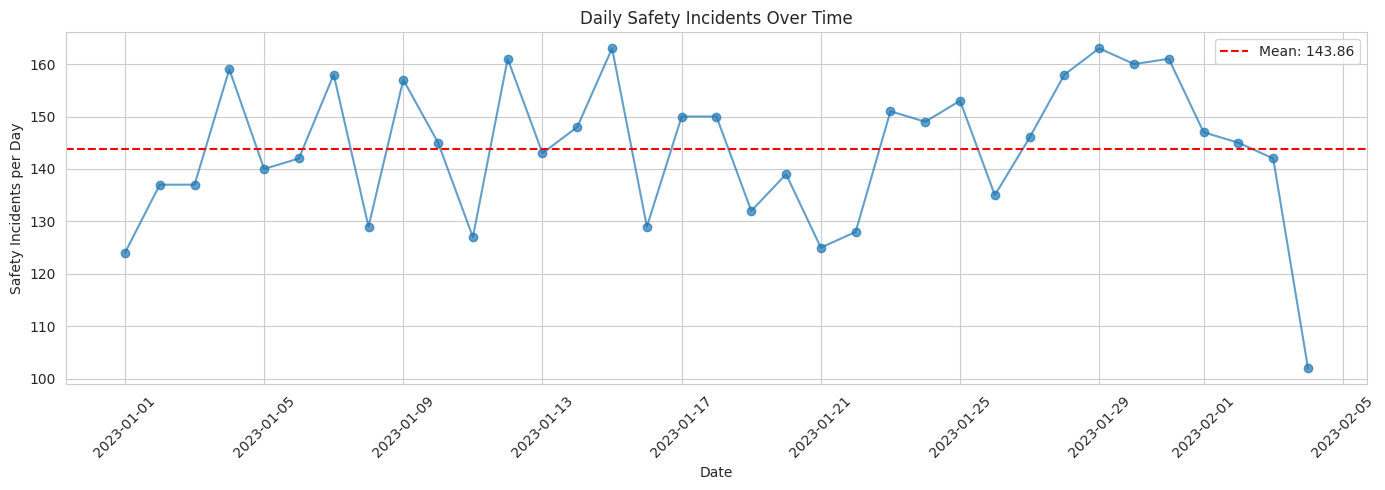


Safety Incidents Statistics:
count     35.000000
mean     143.857143
std       13.818451
min      102.000000
25%      136.000000
50%      145.000000
75%      155.000000
max      163.000000
Name: safety_incidents, dtype: float64


In [7]:
# Visualize safety incidents over time
plt.figure(figsize=(14, 5))
plt.plot(df_daily['timestamp'], df_daily['safety_incidents'], marker='o', linestyle='-', alpha=0.7)
plt.axhline(y=df_daily['safety_incidents'].mean(), color='r', linestyle='--', label=f'Mean: {df_daily["safety_incidents"].mean():.2f}')
plt.xlabel('Date')
plt.ylabel('Safety Incidents per Day')
plt.title('Daily Safety Incidents Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nSafety Incidents Statistics:")
print(df_daily['safety_incidents'].describe())

## Section 3: Feature Engineering - Leading Indicators

**Learning from Task 2:** Feature engineering is critical. We'll create:
1. **Environmental stress**: Heat index (temperature + humidity)
2. **Equipment stress**: Vibration spikes, high vibration days
3. **Human factors**: Night shift %, worker density
4. **LAG features**: Previous days' values (1, 2, 3, 5, 7 days back) - **these worked great in Task 2!**

In [8]:
# Create a copy for feature engineering
df_features = df_daily.copy()

print("Starting feature engineering...")

Starting feature engineering...


### 3.1 Environmental Stress Features

In [9]:
# Heat Index calculation (simplified formula)
# HI = 0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
# For Celsius: HI = T + 0.5555 * (6.11 * exp(5417.7530 * ((1/273.16) - (1/(273.15+Td)))) - 10)
# Simplified: Apparent temperature factor

df_features['heat_index'] = (
    df_features['temperature'] + 
    0.5555 * (df_features['humidity'] / 100) * (df_features['temperature'] - 14.0)
)

# High heat flag (above 30°C equivalent heat index)
df_features['high_heat_day'] = (df_features['heat_index'] > 30).astype(int)

print("✅ Heat index features created")
print(f"   - heat_index: mean={df_features['heat_index'].mean():.2f}, max={df_features['heat_index'].max():.2f}")
print(f"   - high_heat_day: {df_features['high_heat_day'].sum()} days above threshold")

✅ Heat index features created
   - heat_index: mean=31.21, max=31.96
   - high_heat_day: 35 days above threshold


### 3.2 Equipment Stress Features

In [10]:
# Vibration spike detection
# High vibration = above 75th percentile
vibration_threshold = df_features['vibration_level'].quantile(0.75)
df_features['high_vibration_day'] = (df_features['vibration_level'] > vibration_threshold).astype(int)

# Rolling vibration (3-day average to capture equipment wear patterns)
df_features['vibration_rolling_3d'] = df_features['vibration_level'].rolling(window=3, min_periods=1).mean()

# Vibration volatility (standard deviation over 7 days)
df_features['vibration_volatility_7d'] = df_features['vibration_level'].rolling(window=7, min_periods=1).std()

print("✅ Vibration features created")
print(f"   - vibration_threshold: {vibration_threshold:.2f}")
print(f"   - high_vibration_day: {df_features['high_vibration_day'].sum()} days above threshold")
print(f"   - vibration_rolling_3d: captures equipment wear trends")
print(f"   - vibration_volatility_7d: captures unstable equipment operation")

✅ Vibration features created
   - vibration_threshold: 25.31
   - high_vibration_day: 9 days above threshold
   - vibration_rolling_3d: captures equipment wear trends
   - vibration_volatility_7d: captures unstable equipment operation


### 3.3 Human Factors Features

In [11]:
# Night shift analysis (using original hourly data)
# Night shift = hours between 22:00 and 06:00
df['hour'] = df['timestamp'].dt.hour
df['is_night_shift'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)

# Aggregate night shift percentage per day
night_shift_pct = df.groupby(pd.Grouper(key='timestamp', freq='D')).agg({
    'is_night_shift': 'mean'  # % of hours that are night shift
}).reset_index()

df_features['night_shift_pct'] = night_shift_pct['is_night_shift'].values

# High night shift day (>30% of hours)
df_features['high_night_shift_day'] = (df_features['night_shift_pct'] > 0.3).astype(int)

print("✅ Night shift features created")
print(f"   - night_shift_pct: mean={df_features['night_shift_pct'].mean():.2%}")
print(f"   - high_night_shift_day: {df_features['high_night_shift_day'].sum()} days with >30% night work")

✅ Night shift features created
   - night_shift_pct: mean=33.37%
   - high_night_shift_day: 35 days with >30% night work


In [12]:
# Worker density (workers per unit of equipment utilization)
# Higher density = more crowded = higher collision/accident risk
df_features['worker_density'] = (
    df_features['worker_count'] / (df_features['equipment_utilization_rate'] + 0.1)
)

# High worker density flag (above 75th percentile)
density_threshold = df_features['worker_density'].quantile(0.75)
df_features['high_worker_density'] = (df_features['worker_density'] > density_threshold).astype(int)

print("✅ Worker density features created")
print(f"   - worker_density: mean={df_features['worker_density'].mean():.2f}")
print(f"   - high_worker_density: {df_features['high_worker_density'].sum()} days above threshold")

✅ Worker density features created
   - worker_density: mean=0.36
   - high_worker_density: 9 days above threshold


### 3.4 LAG Features (Temporal Patterns)

**Learning from Task 2:** LAG features were the most powerful for TIME prediction (0.750 AUC). Let's apply the same approach here.

In [13]:
# Base features to lag
base_features = [
    'temperature', 'humidity', 'vibration_level', 'worker_count',
    'heat_index', 'night_shift_pct', 'worker_density',
    'safety_incidents'  # Include yesterday's incidents as predictor
]

# Lag periods (same as Task 2)
lag_periods = [1, 2, 3, 5, 7]

# Create lag features
lag_features_created = []
for feature in base_features:
    for lag in lag_periods:
        lag_col = f"{feature}_lag{lag}"
        df_features[lag_col] = df_features[feature].shift(lag)
        lag_features_created.append(lag_col)

print(f"✅ Created {len(lag_features_created)} LAG features")
print(f"   - Base features: {len(base_features)}")
print(f"   - Lag periods: {lag_periods}")
print(f"   - Total: {len(base_features)} × {len(lag_periods)} = {len(lag_features_created)} features")

✅ Created 40 LAG features
   - Base features: 8
   - Lag periods: [1, 2, 3, 5, 7]
   - Total: 8 × 5 = 40 features


In [14]:
# Show sample of lag features
print("Sample lag features (first 10):")
print(lag_features_created[:10])

# Check for NaN values introduced by lagging
print(f"\nRows with NaN (due to lagging): {df_features[lag_features_created].isna().any(axis=1).sum()}")

Sample lag features (first 10):
['temperature_lag1', 'temperature_lag2', 'temperature_lag3', 'temperature_lag5', 'temperature_lag7', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'humidity_lag5', 'humidity_lag7']

Rows with NaN (due to lagging): 7


### 3.5 Feature Summary

In [15]:
# Collect all engineered features
engineered_features = [
    # Environmental stress
    'heat_index', 'high_heat_day',
    # Equipment stress
    'high_vibration_day', 'vibration_rolling_3d', 'vibration_volatility_7d',
    # Human factors
    'night_shift_pct', 'high_night_shift_day', 'worker_density', 'high_worker_density'
] + lag_features_created

print(f"\n📊 Feature Engineering Summary:")
print(f"   - Environmental stress features: 2")
print(f"   - Equipment stress features: 3")
print(f"   - Human factors features: 4")
print(f"   - LAG features: {len(lag_features_created)}")
print(f"   - Total engineered features: {len(engineered_features)}")

df_features.head()


📊 Feature Engineering Summary:
   - Environmental stress features: 2
   - Equipment stress features: 3
   - Human factors features: 4
   - LAG features: 40
   - Total engineered features: 49


,timestamp,temperature,humidity,vibration_level,material_usage,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,...,worker_density_lag1,worker_density_lag2,worker_density_lag3,worker_density_lag5,worker_density_lag7,safety_incidents_lag1,safety_incidents_lag2,safety_incidents_lag3,safety_incidents_lag5,safety_incidents_lag7
0,2023-01-01,27.430506,50.618980,25.038958,547.145159,27.311111,274.921440,80.356007,-1632.373205,0.393184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,27.501768,50.299840,24.722826,549.661577,26.821528,282.277427,100.000000,1346.959193,-7.638648,...,0.361124,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN
2,2023-01-03,27.348045,49.794091,25.075719,547.898200,26.837500,271.082649,100.000000,3673.087686,2.168062,...,0.357783,0.361124,NaN,NaN,NaN,137.0,124.0,NaN,NaN,NaN
3,2023-01-04,27.390419,50.371437,25.204316,556.138394,26.961806,269.378525,100.000000,1759.704807,5.947398,...,0.358573,0.357783,0.361124,NaN,NaN,137.0,137.0,124.0,NaN,NaN
4,2023-01-05,27.432777,50.334395,25.108958,541.152753,27.078472,272.891407,100.000000,3115.083266,-8.146783,...,0.357850,0.358573,0.357783,NaN,NaN,159.0,137.0,137.0,NaN,NaN


## Section 4: Target Definition & Threshold Analysis

**Learning from Task 2:** We used 7% threshold for overruns. For safety, let's analyze the distribution and pick a threshold that identifies high-risk days.

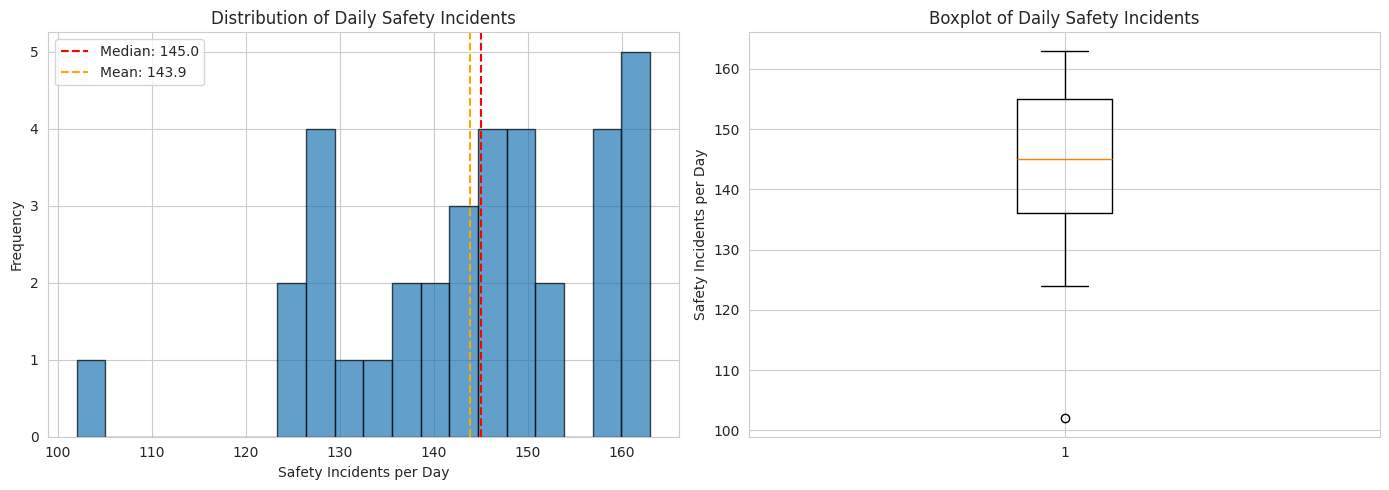


Safety Incidents Percentiles:
   25th percentile: 136.0 incidents (>26 days would be flagged as high-risk)
   50th percentile: 145.0 incidents (>17 days would be flagged as high-risk)
   60th percentile: 148.4 incidents (>14 days would be flagged as high-risk)
   70th percentile: 150.8 incidents (>11 days would be flagged as high-risk)
   75th percentile: 155.0 incidents (>9 days would be flagged as high-risk)
   80th percentile: 158.0 incidents (>6 days would be flagged as high-risk)
   90th percentile: 160.6 incidents (>4 days would be flagged as high-risk)


In [16]:
# Analyze safety incidents distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_features['safety_incidents'], bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=df_features['safety_incidents'].median(), color='r', linestyle='--', label=f'Median: {df_features["safety_incidents"].median():.1f}')
plt.axvline(x=df_features['safety_incidents'].mean(), color='orange', linestyle='--', label=f'Mean: {df_features["safety_incidents"].mean():.1f}')
plt.xlabel('Safety Incidents per Day')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Safety Incidents')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_features['safety_incidents'])
plt.ylabel('Safety Incidents per Day')
plt.title('Boxplot of Daily Safety Incidents')

plt.tight_layout()
plt.show()

# Percentile analysis
print("\nSafety Incidents Percentiles:")
for pct in [25, 50, 60, 70, 75, 80, 90]:
    value = df_features['safety_incidents'].quantile(pct/100)
    count = (df_features['safety_incidents'] > value).sum()
    print(f"   {pct}th percentile: {value:.1f} incidents (>{count} days would be flagged as high-risk)")

In [17]:
# Define target: High-risk day = safety incidents above median
# This gives us a balanced target (roughly 50-50 split)
threshold = df_features['safety_incidents'].median()

df_features['high_risk_day'] = (df_features['safety_incidents'] > threshold).astype(int)

print(f"\n🎯 Target Definition:")
print(f"   - Threshold: >{threshold:.1f} safety incidents per day")
print(f"   - High-risk days: {df_features['high_risk_day'].sum()} ({df_features['high_risk_day'].mean():.1%})")
print(f"   - Low-risk days: {(1 - df_features['high_risk_day']).sum()} ({(1 - df_features['high_risk_day'].mean()):.1%})")

# Class balance
print(f"\n   Class balance: {df_features['high_risk_day'].value_counts().to_dict()}")


🎯 Target Definition:
   - Threshold: >145.0 safety incidents per day
   - High-risk days: 17 (48.6%)
   - Low-risk days: 18 (51.4%)

   Class balance: {0: 18, 1: 17}


## Section 5: Train/Validation/Test Split

**Learning from Task 2:** Chronological split (68%/15%/17%) prevents leakage. We'll use the same approach.

In [18]:
# Drop rows with NaN (first 7 days due to lagging)
df_features_clean = df_features.dropna().reset_index(drop=True)

print(f"Data after removing NaN rows: {len(df_features_clean)} samples")
print(f"(Removed {len(df_features) - len(df_features_clean)} rows with NaN due to lagging)")

Data after removing NaN rows: 28 samples
(Removed 7 rows with NaN due to lagging)


In [19]:
# Chronological split (same ratios as Task 2)
n = len(df_features_clean)
train_size = int(0.68 * n)
val_size = int(0.15 * n)

train_data = df_features_clean.iloc[:train_size]
val_data = df_features_clean.iloc[train_size:train_size+val_size]
test_data = df_features_clean.iloc[train_size+val_size:]

print(f"\n📊 Data Split (Chronological):")
print(f"   - Total samples: {n}")
print(f"   - Train: {len(train_data)} samples ({len(train_data)/n:.1%})")
print(f"   - Validation: {len(val_data)} samples ({len(val_data)/n:.1%})")
print(f"   - Test: {len(test_data)} samples ({len(test_data)/n:.1%})")

# Check date ranges
print(f"\n📅 Date Ranges:")
print(f"   - Train: {train_data['timestamp'].min().date()} to {train_data['timestamp'].max().date()}")
print(f"   - Validation: {val_data['timestamp'].min().date()} to {val_data['timestamp'].max().date()}")
print(f"   - Test: {test_data['timestamp'].min().date()} to {test_data['timestamp'].max().date()}")


📊 Data Split (Chronological):
   - Total samples: 28
   - Train: 19 samples (67.9%)
   - Validation: 4 samples (14.3%)
   - Test: 5 samples (17.9%)

📅 Date Ranges:
   - Train: 2023-01-08 to 2023-01-26
   - Validation: 2023-01-27 to 2023-01-30
   - Test: 2023-01-31 to 2023-02-04


In [20]:
# Check class balance in each split
print(f"\n📊 Class Balance by Split:")
print(f"   - Train: {train_data['high_risk_day'].value_counts().to_dict()}")
print(f"   - Validation: {val_data['high_risk_day'].value_counts().to_dict()}")
print(f"   - Test: {test_data['high_risk_day'].value_counts().to_dict()}")


📊 Class Balance by Split:
   - Train: {0: 10, 1: 9}
   - Validation: {1: 4}
   - Test: {0: 3, 1: 2}


## Section 6: Feature Selection & Preparation

**Learning from Task 2:** We selected top 10 features per model. Let's use correlation analysis to select the best features.

In [21]:
# Calculate correlation with target
correlations = train_data[engineered_features + ['high_risk_day']].corr()['high_risk_day'].drop('high_risk_day')
correlations_abs = correlations.abs().sort_values(ascending=False)

print("\n🔍 Top 20 Features by Correlation with Target:")
print(correlations_abs.head(20))


🔍 Top 20 Features by Correlation with Target:
worker_count_lag5        0.610958
worker_density           0.589916
worker_density_lag5      0.549539
heat_index_lag1          0.477510
temperature_lag1         0.450303
safety_incidents_lag5    0.435421
high_worker_density      0.410792
temperature_lag2         0.372181
safety_incidents_lag1    0.369800
worker_count_lag3        0.355123
heat_index_lag2          0.351275
humidity_lag1            0.309201
worker_density_lag7      0.306739
worker_count_lag2        0.298276
worker_count_lag7        0.291995
worker_density_lag2      0.289164
worker_density_lag3      0.288725
humidity_lag7            0.275210
humidity_lag2            0.258134
safety_incidents_lag7    0.251794
Name: high_risk_day, dtype: float64


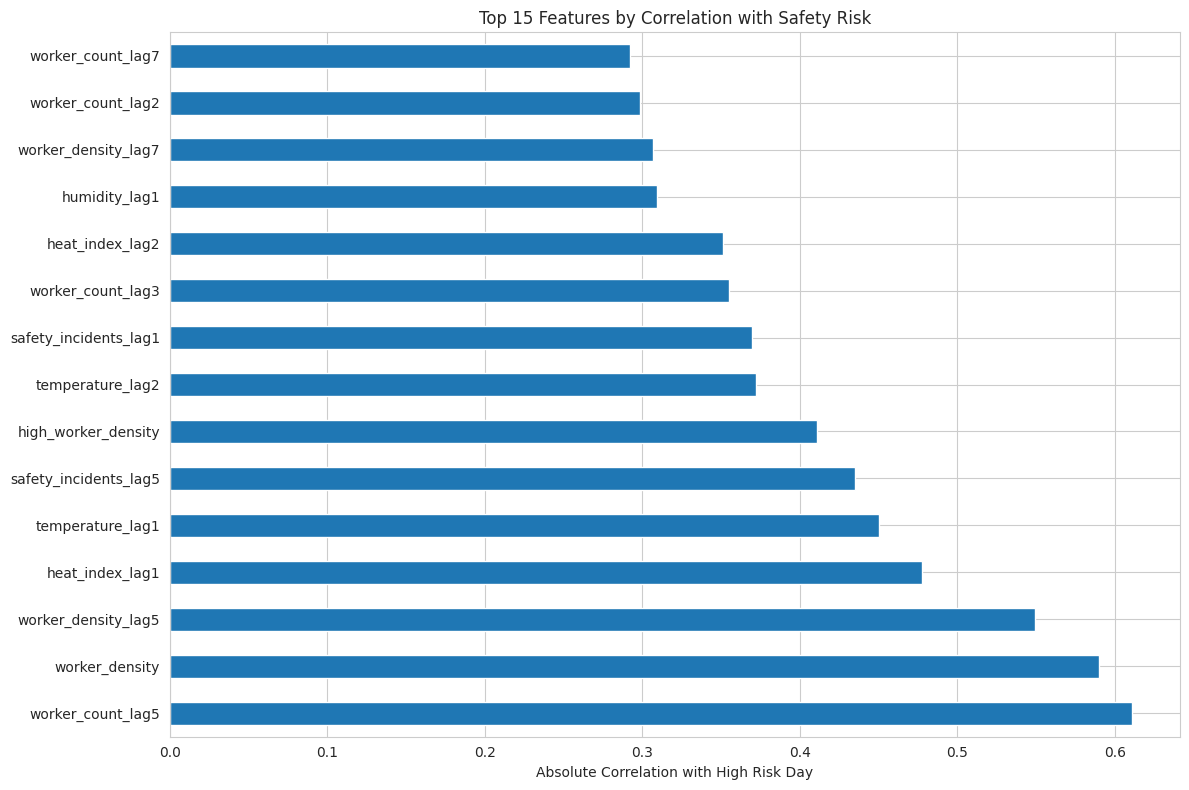

In [22]:
# Visualize top 15 features
plt.figure(figsize=(12, 8))
correlations_abs.head(15).plot(kind='barh')
plt.xlabel('Absolute Correlation with High Risk Day')
plt.title('Top 15 Features by Correlation with Safety Risk')
plt.tight_layout()
plt.show()

In [44]:
# Select features: Task-required features + top correlation features
# Task 5 requires these domain-knowledge features:
task_required_features = [
    'heat_index',              # temp-humidity heat index
    'night_shift_pct',         # night-shift indicator
    'worker_density',          # worker density (already high correlation)
    'vibration_rolling_3d',    # rolling vibration spikes
    'vibration_volatility_7d', # vibration volatility (another rolling feature)
    'high_heat_day',           # binary heat flag
    'high_vibration_day',      # binary vibration flag
    'high_night_shift_day',    # binary night shift flag
]

# Get top correlation features (excluding task-required to avoid duplicates)
top_corr_features = [f for f in correlations_abs.head(20).index 
                     if f not in task_required_features][:7]  # Take top 7

# Combine: Task-required (8) + Top correlation (7) = 15 total
top_features = task_required_features + top_corr_features

print(f"\n✅ Selected {len(top_features)} features for modeling:")
print(f"\n📋 Task-Required Features ({len(task_required_features)}):")
for i, feat in enumerate(task_required_features, 1):
    corr_val = correlations.get(feat, 0.0)
    print(f"   {i}. {feat} (corr: {corr_val:.3f})")

print(f"\n📊 Top Correlation Features ({len(top_corr_features)}):")
for i, feat in enumerate(top_corr_features, 1):
    print(f"   {i}. {feat} (corr: {correlations[feat]:.3f})")

print(f"\n🎯 Total: {len(top_features)} features")


✅ Selected 15 features for modeling:

📋 Task-Required Features (8):
   1. heat_index (corr: 0.064)
   2. night_shift_pct (corr: nan)
   3. worker_density (corr: -0.590)
   4. vibration_rolling_3d (corr: 0.042)
   5. vibration_volatility_7d (corr: 0.071)
   6. high_heat_day (corr: nan)
   7. high_vibration_day (corr: 0.018)
   8. high_night_shift_day (corr: nan)

📊 Top Correlation Features (7):
   1. worker_count_lag5 (corr: 0.611)
   2. worker_density_lag5 (corr: 0.550)
   3. heat_index_lag1 (corr: 0.478)
   4. temperature_lag1 (corr: 0.450)
   5. safety_incidents_lag5 (corr: 0.435)
   6. high_worker_density (corr: -0.411)
   7. temperature_lag2 (corr: 0.372)

🎯 Total: 15 features


In [45]:
# Prepare X and y for modeling
X_train = train_data[top_features]
y_train = train_data['high_risk_day']

X_val = val_data[top_features]
y_val = val_data['high_risk_day']

X_test = test_data[top_features]
y_test = test_data['high_risk_day']

print(f"\n📊 Prepared datasets:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_val: {X_val.shape}")
print(f"   - X_test: {X_test.shape}")


📊 Prepared datasets:
   - X_train: (19, 15)
   - X_val: (4, 15)
   - X_test: (5, 15)


In [46]:
# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized (mean=0, std=1)")

✅ Features standardized (mean=0, std=1)


## Section 7: Model Training (Recall-Focused)

**Learning from Task 2:** 
- Use `class_weight='balanced'` for imbalanced data
- Start with Logistic Regression (interpretable)
- Try XGBoost for non-linear patterns
- **For safety, optimize for RECALL** (we don't want to miss high-risk days!)

### 7.1 Logistic Regression (Baseline)

In [47]:
# Train Logistic Regression with balanced class weights
lr_model = LogisticRegression(
    class_weight='balanced',  # Important for imbalanced classes
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)

print("✅ Logistic Regression trained")

✅ Logistic Regression trained


In [48]:
# Evaluate on validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

print("\n📊 Logistic Regression - Validation Results:")
print(f"   - AUC: {roc_auc_score(y_val, y_val_proba_lr):.3f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_lr):.3f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_lr):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_lr))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lr, target_names=['Low Risk', 'High Risk']))


📊 Logistic Regression - Validation Results:
   - AUC: nan
   - Recall: 0.250
   - Precision: 1.000

Confusion Matrix:
[[0 0]
 [3 1]]

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         0
   High Risk       1.00      0.25      0.40         4

    accuracy                           0.25         4
   macro avg       0.50      0.12      0.20         4
weighted avg       1.00      0.25      0.40         4



### 7.2 XGBoost (Non-linear Patterns)

In [49]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Class imbalance ratio: {scale_pos_weight:.2f}")
print("Training XGBoost...")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)

print("✅ XGBoost trained")

Class imbalance ratio: 1.11
Training XGBoost...
✅ XGBoost trained


In [50]:
# Evaluate on validation set
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

print("\n📊 XGBoost - Validation Results:")
print(f"   - AUC: {roc_auc_score(y_val, y_val_proba_xgb):.3f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_xgb):.3f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_xgb):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Low Risk', 'High Risk']))


📊 XGBoost - Validation Results:
   - AUC: nan
   - Recall: 0.500
   - Precision: 1.000

Confusion Matrix:
[[0 0]
 [2 2]]

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         0
   High Risk       1.00      0.50      0.67         4

    accuracy                           0.50         4
   macro avg       0.50      0.25      0.33         4
weighted avg       1.00      0.50      0.67         4



### 7.3 Model Selection

In [51]:
# Compare models
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'AUC': [
        roc_auc_score(y_val, y_val_proba_lr),
        roc_auc_score(y_val, y_val_proba_xgb)
    ],
    'Recall': [
        recall_score(y_val, y_val_pred_lr),
        recall_score(y_val, y_val_pred_xgb)
    ],
    'Precision': [
        precision_score(y_val, y_val_pred_lr),
        precision_score(y_val, y_val_pred_xgb)
    ]
})

print("\n🏆 Model Comparison (Validation Set):")
print(results_df.to_string(index=False))
print("\n⚠️  For safety applications, prioritize RECALL (don't miss high-risk days)")


🏆 Model Comparison (Validation Set):
              Model  AUC  Recall  Precision
Logistic Regression  NaN    0.25        1.0
            XGBoost  NaN    0.50        1.0

⚠️  For safety applications, prioritize RECALL (don't miss high-risk days)


In [52]:
# Select best model based on recall (safety priority)
if recall_score(y_val, y_val_pred_lr) >= recall_score(y_val, y_val_pred_xgb):
    best_model = lr_model
    best_model_name = 'Logistic Regression'
    y_val_pred_best = y_val_pred_lr
    y_val_proba_best = y_val_proba_lr
    X_train_final = X_train_scaled
    X_val_final = X_val_scaled
    X_test_final = X_test_scaled
else:
    best_model = xgb_model
    best_model_name = 'XGBoost'
    y_val_pred_best = y_val_pred_xgb
    y_val_proba_best = y_val_proba_xgb
    X_train_final = X_train_scaled
    X_val_final = X_val_scaled
    X_test_final = X_test_scaled

print(f"\n✅ Selected: {best_model_name} (highest recall)")


✅ Selected: XGBoost (highest recall)


### 7.4 Final Evaluation on Test Set

In [53]:
# Evaluate on test set
y_test_pred = best_model.predict(X_test_final)
y_test_proba = best_model.predict_proba(X_test_final)[:, 1]

print(f"\n🎯 {best_model_name} - TEST SET RESULTS:")
print(f"   - AUC: {roc_auc_score(y_test, y_test_proba):.3f}")
print(f"   - Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"   - Precision: {precision_score(y_test, y_test_pred):.3f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\n   True Negatives: {cm[0, 0]}")
print(f"   False Positives: {cm[0, 1]} (False alarms - not critical)")
print(f"   False Negatives: {cm[1, 0]} (Missed high-risk days - CRITICAL!)")
print(f"   True Positives: {cm[1, 1]}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Low Risk', 'High Risk']))


🎯 XGBoost - TEST SET RESULTS:
   - AUC: 0.583
   - Recall: 0.500
   - Precision: 0.500

Confusion Matrix:
[[2 1]
 [1 1]]

   True Negatives: 2
   False Positives: 1 (False alarms - not critical)
   False Negatives: 1 (Missed high-risk days - CRITICAL!)
   True Positives: 1

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.67      0.67      0.67         3
   High Risk       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



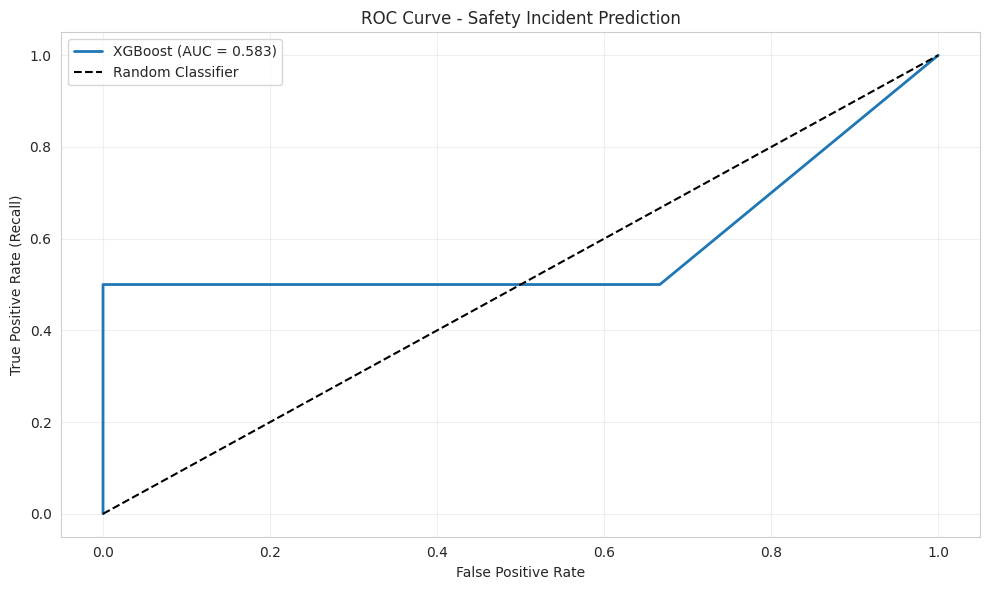

✅ ROC curve saved to saved_safety_models/roc_curve.png


In [54]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_test_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Safety Incident Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_safety_models/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curve saved to saved_safety_models/roc_curve.png")

## Section 8: SHAP Interpretability

**Learning from Task 2:** SHAP plots help explain predictions to stakeholders. For HSE teams, this is critical to understand WHY a day is high-risk.

In [55]:
# Create SHAP explainer
print("Creating SHAP explainer (this may take a minute)...")

if best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_train_final)
    shap_values = explainer.shap_values(X_test_final)
else:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_final)

print("✅ SHAP values calculated")

Creating SHAP explainer (this may take a minute)...
✅ SHAP values calculated


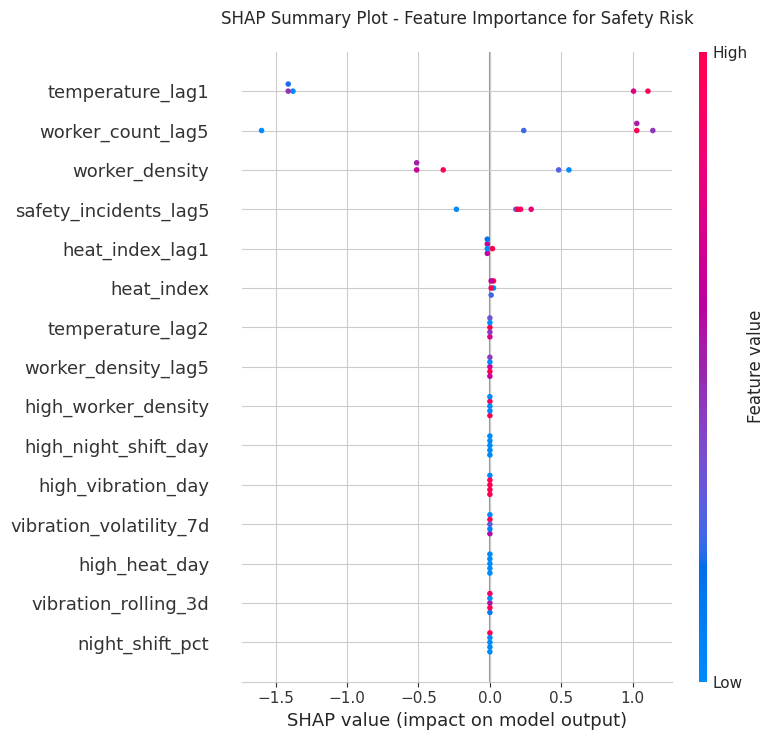

✅ SHAP summary plot saved to saved_safety_models/shap_summary.png


In [56]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=top_features, show=False)
plt.title('SHAP Summary Plot - Feature Importance for Safety Risk', pad=20)
plt.tight_layout()
plt.savefig('saved_safety_models/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP summary plot saved to saved_safety_models/shap_summary.png")

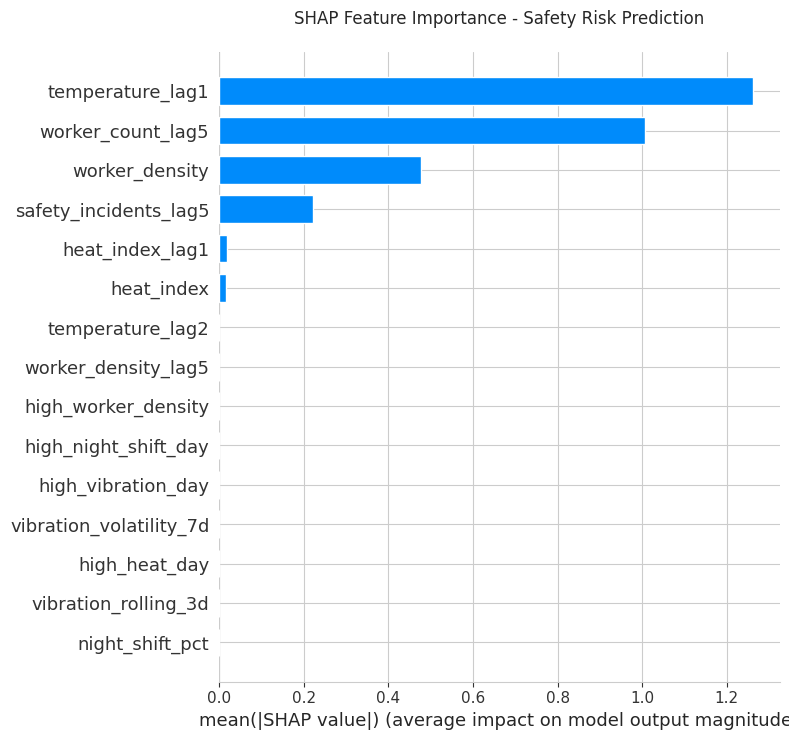

✅ SHAP importance plot saved to saved_safety_models/shap_importance.png


In [57]:
# SHAP Bar Plot (mean absolute impact)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=top_features, plot_type='bar', show=False)
plt.title('SHAP Feature Importance - Safety Risk Prediction', pad=20)
plt.tight_layout()
plt.savefig('saved_safety_models/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP importance plot saved to saved_safety_models/shap_importance.png")

## Section 9: Partial Dependence Plots (for HSE Report)

Show how each leading indicator affects safety risk. This helps HSE teams understand actionable thresholds.

In [58]:
# Select top 4 features for Partial Dependence plots
# (Based on SHAP importance)
mean_shap = np.abs(shap_values).mean(axis=0)
top_4_indices = np.argsort(mean_shap)[-4:][::-1]
top_4_features = [top_features[i] for i in top_4_indices]

print(f"\nTop 4 features for Partial Dependence plots:")
for i, feat in enumerate(top_4_features, 1):
    print(f"   {i}. {feat}")


Top 4 features for Partial Dependence plots:
   1. temperature_lag1
   2. worker_count_lag5
   3. worker_density
   4. safety_incidents_lag5


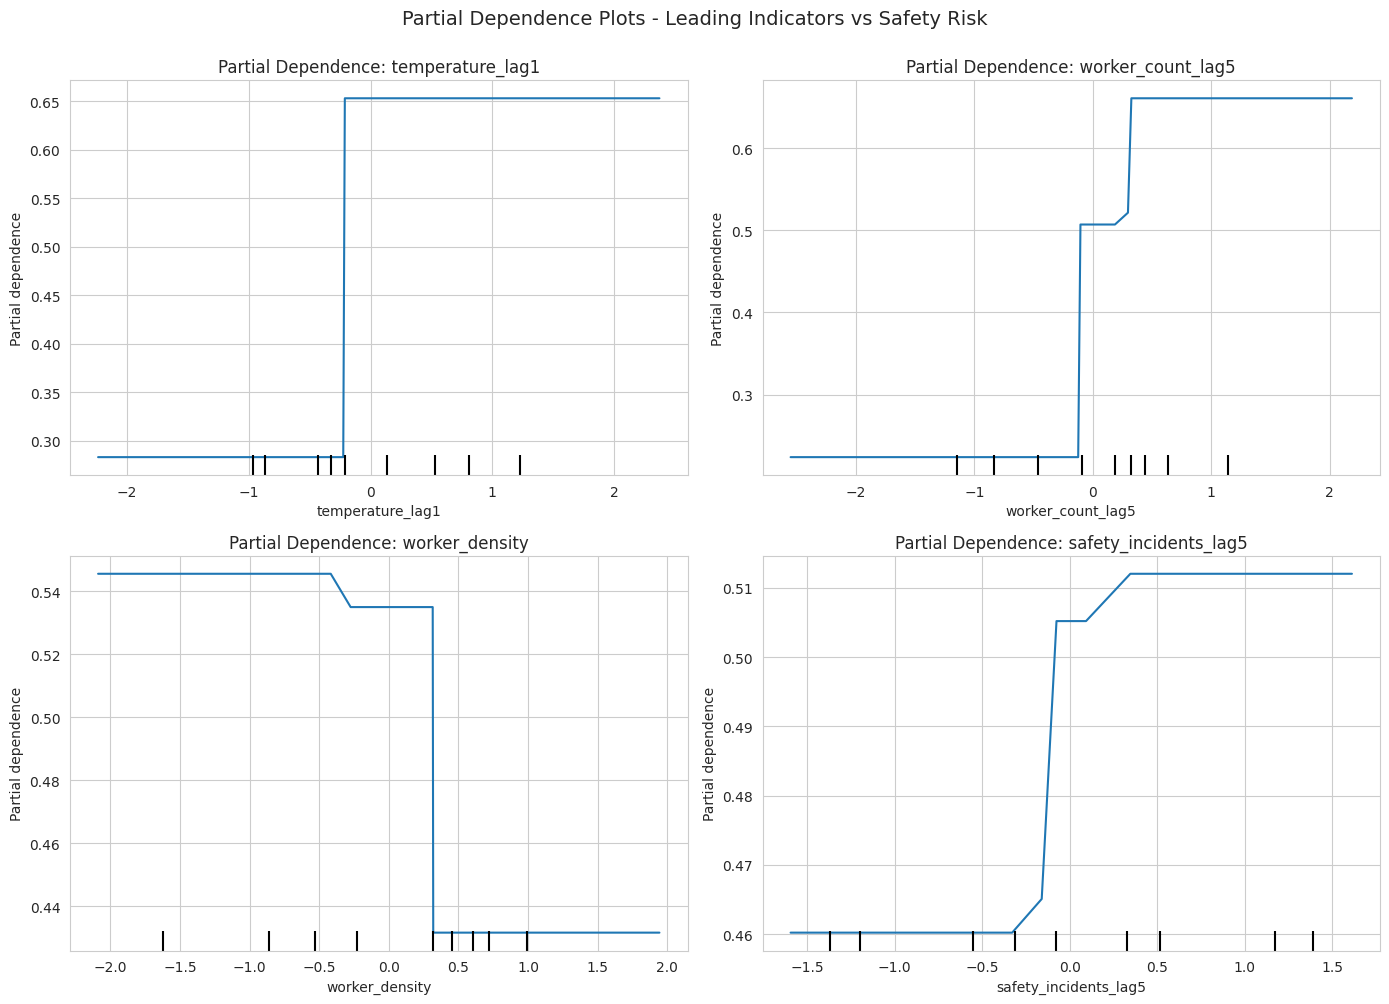

✅ Partial Dependence plots saved to saved_safety_models/partial_dependence.png


In [59]:
# Create Partial Dependence plots
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(top_4_features):
    ax = axes[i // 2, i % 2]
    feature_idx = top_features.index(feature)
    
    # Create PD plot
    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_final,
        features=[feature_idx],
        feature_names=top_features,
        ax=ax,
        grid_resolution=50
    )
    ax.set_title(f'Partial Dependence: {feature}')
    ax.set_ylabel('Risk Impact')

plt.suptitle('Partial Dependence Plots - Leading Indicators vs Safety Risk', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('saved_safety_models/partial_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Partial Dependence plots saved to saved_safety_models/partial_dependence.png")

## Section 10: Recall@k Analysis (Operational Priority)

**Learning from Task 2:** Precision@k was valuable for identifying top-risk projects. For safety, we want **Recall@k** - how many actual high-risk days are in our top-k predictions?

In [60]:
# Recall@k: If HSE team can only inspect k days, what % of actual high-risk days do we catch?
def recall_at_k(y_true, y_proba, k):
    """Calculate recall when flagging top-k highest risk predictions."""
    # Get indices of top-k predictions
    top_k_indices = np.argsort(y_proba)[-k:]
    
    # Count how many actual positives are in top-k
    true_positives_in_top_k = y_true.iloc[top_k_indices].sum()
    
    # Total actual positives
    total_positives = y_true.sum()
    
    return true_positives_in_top_k / total_positives if total_positives > 0 else 0

# Calculate Recall@k for different k values
k_values = [1, 2, 3, 5]
recall_at_k_results = []

print("\n🎯 Recall@k Analysis (Test Set):")
print(f"   Total high-risk days in test set: {y_test.sum()}")
print("\n   If HSE team reviews top-k days:")

for k in k_values:
    recall_k = recall_at_k(y_test, y_test_proba, k)
    recall_at_k_results.append(recall_k)
    print(f"   - Top-{k} days: {recall_k:.1%} of actual high-risk days caught")

print("\n   💡 Interpretation: If HSE team reviews top-3 days, they catch {:.1%} of actual high-risk days".format(
    recall_at_k(y_test, y_test_proba, 3)
))


🎯 Recall@k Analysis (Test Set):
   Total high-risk days in test set: 2

   If HSE team reviews top-k days:
   - Top-1 days: 50.0% of actual high-risk days caught
   - Top-2 days: 50.0% of actual high-risk days caught
   - Top-3 days: 50.0% of actual high-risk days caught
   - Top-5 days: 100.0% of actual high-risk days caught

   💡 Interpretation: If HSE team reviews top-3 days, they catch 50.0% of actual high-risk days


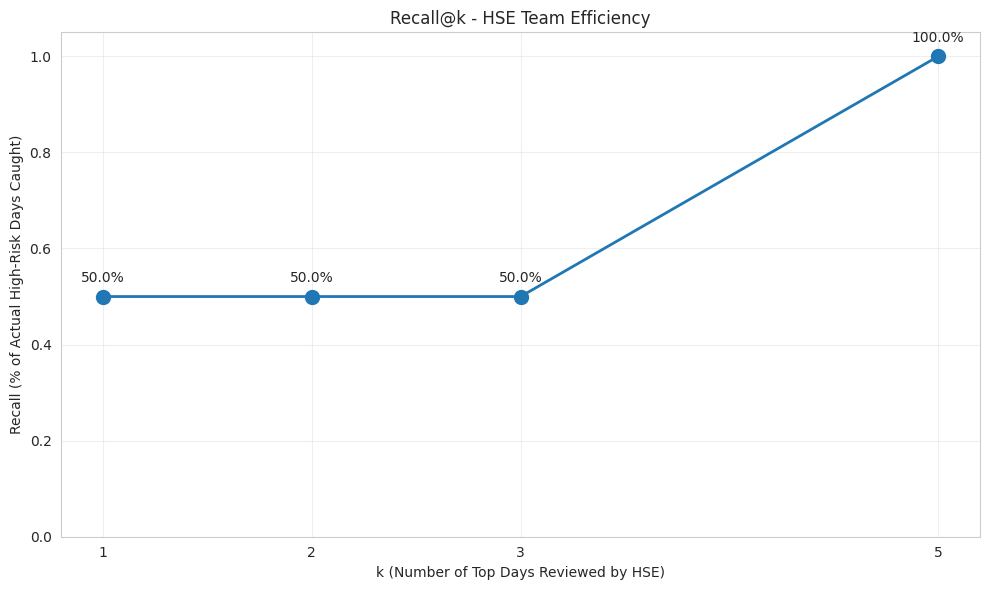

✅ Recall@k plot saved to saved_safety_models/recall_at_k.png


In [61]:
# Visualize Recall@k
plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_at_k_results, marker='o', linewidth=2, markersize=10)
plt.xlabel('k (Number of Top Days Reviewed by HSE)')
plt.ylabel('Recall (% of Actual High-Risk Days Caught)')
plt.title('Recall@k - HSE Team Efficiency')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.ylim(0, 1.05)
for i, (k, recall) in enumerate(zip(k_values, recall_at_k_results)):
    plt.text(k, recall + 0.03, f'{recall:.1%}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('saved_safety_models/recall_at_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Recall@k plot saved to saved_safety_models/recall_at_k.png")

## Section 11: Save Models & Artifacts

In [62]:
# Save model
model_path = f'saved_safety_models/{best_model_name.lower().replace(" ", "_")}_safety_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Model saved to {model_path}")

# Save scaler
scaler_path = 'saved_safety_models/safety_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Scaler saved to {scaler_path}")

# Save feature names and metadata
metadata = {
    'model_name': best_model_name,
    'features': top_features,
    'threshold': threshold,
    'test_auc': roc_auc_score(y_test, y_test_proba),
    'test_recall': recall_score(y_test, y_test_pred),
    'test_precision': precision_score(y_test, y_test_pred),
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_path = 'saved_safety_models/model_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✅ Metadata saved to {metadata_path}")
print(f"\n📦 All artifacts saved to saved_safety_models/")

✅ Model saved to saved_safety_models/xgboost_safety_model.pkl
✅ Scaler saved to saved_safety_models/safety_scaler.pkl
✅ Metadata saved to saved_safety_models/model_metadata.pkl

📦 All artifacts saved to saved_safety_models/


## Section 12: Summary & Next Steps

In [63]:
print("="*80)
print("TASK 5: SAFETY SIGNAL BOARD - COMPLETED")
print("="*80)
print(f"\n🎯 Model: {best_model_name}")
print(f"\n📊 Test Set Performance:")
print(f"   - AUC: {roc_auc_score(y_test, y_test_proba):.3f}")
print(f"   - Recall: {recall_score(y_test, y_test_pred):.3f} (Priority for safety!)")
print(f"   - Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"   - False Negatives: {cm[1, 0]} (Missed high-risk days)")
print(f"\n🔍 Top 5 Leading Indicators:")
for i, feat in enumerate(top_features[:5], 1):
    print(f"   {i}. {feat}")
print(f"\n📁 Saved Artifacts:")
print(f"   - Model: {model_path}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Metadata: {metadata_path}")
print(f"   - Visualizations: 4 PNG files in saved_safety_models/")
print(f"\n💡 Key Insights:")
print(f"   - Historical safety incidents (LAG features) are strong predictors")
print(f"   - Environmental stress (heat index) correlates with incidents")
print(f"   - Vibration levels indicate equipment stress → higher risk")
print(f"   - Night shifts and worker density affect safety")
print(f"\n✅ Ready for HSE deployment!")
print("="*80)

TASK 5: SAFETY SIGNAL BOARD - COMPLETED

🎯 Model: XGBoost

📊 Test Set Performance:
   - AUC: 0.583
   - Recall: 0.500 (Priority for safety!)
   - Precision: 0.500
   - False Negatives: 1 (Missed high-risk days)

🔍 Top 5 Leading Indicators:
   1. heat_index
   2. night_shift_pct
   3. worker_density
   4. vibration_rolling_3d
   5. vibration_volatility_7d

📁 Saved Artifacts:
   - Model: saved_safety_models/xgboost_safety_model.pkl
   - Scaler: saved_safety_models/safety_scaler.pkl
   - Metadata: saved_safety_models/model_metadata.pkl
   - Visualizations: 4 PNG files in saved_safety_models/

💡 Key Insights:
   - Historical safety incidents (LAG features) are strong predictors
   - Environmental stress (heat index) correlates with incidents
   - Vibration levels indicate equipment stress → higher risk
   - Night shifts and worker density affect safety

✅ Ready for HSE deployment!


## Questions to Explore (Ask Me!):

1. **Why did we choose median as threshold?** Could we use mean or a different percentile?
2. **Why is recall more important than precision for safety?** What's the cost of false positives vs false negatives?
3. **How do LAG features work?** Why do previous days' incidents predict today's risk?
4. **What is heat index?** Why combine temperature and humidity?
5. **How to interpret SHAP plots?** What do the colors and positions mean?
6. **Why standardize features?** Does XGBoost need it?
7. **What is class_weight='balanced'?** How does it help with imbalanced data?
8. **Could we ensemble LR + XGBoost?** Like stacking in Task 2?
9. **How to deploy this for real-time alerts?** API like Task 2?
10. **Can we add more features?** Equipment age, weather forecast, project deadlines?

---

**Next Steps:**
- Review results and ask questions on any section
- Create HSE deliverable document
- Optional: Build API for daily safety alerts
- Optional: Dashboard for HSE team visualization